In [6]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy as np
from pycuda import gpuarray
from pycuda.compiler import SourceModule
from IPython.display import Image as display_image
from okiya import draw_tiles, bin_interpretation, split_list_n, unzip, turn_number

In [7]:
player = 0 # Red player
#player = 1 # Black player

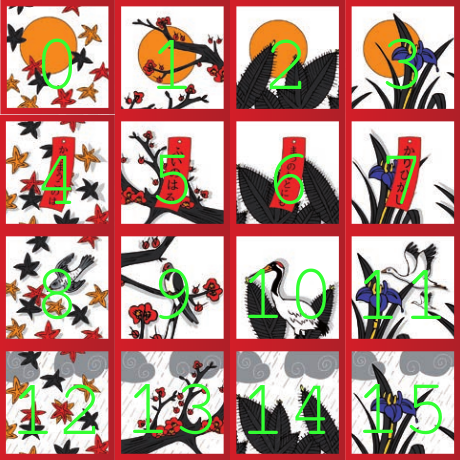

In [8]:
tiles = np.array([i for i in range(0,16)]).reshape([4,4])
img_path = draw_tiles(tiles, draw_numbers = True, hi_res = False)
display_image(img_path)

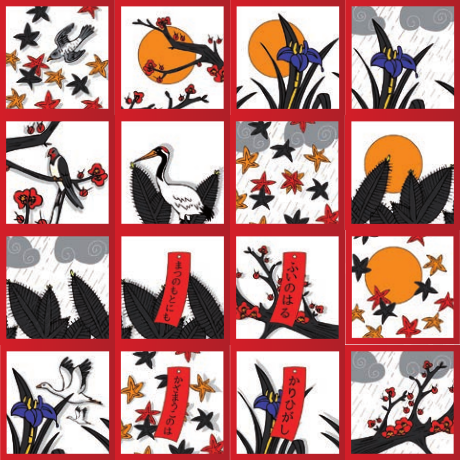

In [9]:
init_tiles = np.array([
    [8,1,3,15],
    [9,10,12,2],
    [14,6,5,0],
    [11,4,7,13]
])
img_path = draw_tiles(init_tiles, draw_numbers = False, hi_res = False)
display_image(img_path)

In [37]:
len(bin_interpretation(2147483647))

31

В карте 1080-ti, MAX_GRID_DIM_X = 2 147 483 647, что позволяет обрабатывать за один такт 2 млрд комбинаций.  
Упаковать их можно в 31 бите.  
План действий:  
1. Вычисляем общее количество возможных победных комбинаций на последнем ходе: 2145. Это 12 бит.  
2. Задаем изначальное расположение тайлов на поле  
3. Все комбинации маски поля это 16 единиц, или 16 бит.  
4. Для каждого хода, передаем в ядро:  
- Текущий ход: от 0 до 15  
- Игрок, победа которого нас интересует: 0 или 1  
- Расположение тайлов игры и фишек игроков: 16 значений от 0 до 17. 16 и 17 - фишки игроков.  
- Входной вектор смещений побед: 2145  
- Выходной вектор: Пакет побед и комбинаций маски  

# 16

In [10]:
ker = SourceModule("""
__device__ bool win_combination(int i)
{
    int win[17]={
    61440, // row 0
    3840,  // row 1
    240,   // row 2
    15,    // row 3
    34952, // col 0
    17476, // col 1
    8738,  // col 2
    4369,  // col 3
    52224, // quad 0
    26112, // quad 1
    13056, // quad 2
    3264,  // quad 3
    1632,  // quad 4
    816,   // quad 5
    204,   // quad 6
    102,   // quad 7
    51     // quad 8
    };
    for (int a=0;a<17;a++) if ((i&win[a])==win[a]) return(true);    
    return(false);
}

__global__ void turn(int player, int turn_id, float *out_vec)
{
    // Нулевые ячейки
    unsigned int zeros[16] = {32767,49151,57343,61439,63487,64511,65023,65279,65407,65471,65503,65519,65527,65531,65533,65534};
    
    // Связи тайлов
    unsigned char relations[16][6] = {
    { 1,  2,  3,  4,  8, 12}, 
    { 0,  2,  3,  5,  9, 13}, 
    { 0,  1,  3,  6, 10, 14}, 
    { 0,  1,  2,  7, 11, 15}, 
    { 0,  5,  6,  7,  8, 12}, 
    { 1,  4,  6,  7,  9, 13}, 
    { 2,  4,  5,  7, 10, 14}, 
    { 3,  4,  5,  6, 11, 15}, 
    { 0,  4,  9, 10, 11, 12}, 
    { 1,  5,  8, 10, 11, 13}, 
    { 2,  6,  8,  9, 11, 14}, 
    { 3,  7,  8,  9, 10, 15}, 
    { 0,  4,  8, 13, 14, 15}, 
    { 1,  5,  9, 12, 14, 15}, 
    { 2,  6, 10, 12, 13, 15}, 
    { 3,  7, 11, 12, 13, 14}
    };
    
    // Количество фишек нулевого игрока на каждом ходу игры
    unsigned char turn_player_count[16] = {1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8};

    int ones = 0;
    int a = 0;
    
    // Идентификатор блока-потока
    unsigned int i = threadIdx.x + blockIdx.x * blockDim.x;
    
    //Распаковка идентификаторов игры
    unsigned char tail_count = 15-turn_id;
    unsigned int comb; // Одна из победных комбинаций
    if (turn_id==15) comb = i;
    else comb = i&4095; // mask_16:[1111111111111111] bias_12:>100001100001<
    
    //Обнуление фишек игрока
    unsigned char c,col,cell[16];
    // Идентификатор ячейки
    for (c=0;c<tail_count;c++) cell[c] = i>>12;
    //>>(4*c)&15;
    
    // Убедимся, что число единиц и нулей в комбинации соответствует ходу
    for(a=0;a<16;a++) if ((((int)round(pow(2,a)))&comb)>0) ones++;
    
    // Проверим, победна ли комбинация выбранного игрока среди возможных
    unsigned int win_tester;
    if (player) win_tester = comb;
    else win_tester = ~comb;
    if (ones==turn_player_count[turn_id] && win_combination(win_tester) && !win_combination(~win_tester)) out_vec[i] = 1;
}
""")

<ipython-input-10-eadfe86c7213>:1: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(31): warning #177-D: variable "zeros" was declared but never referenced

kernel.cu(34): warning #177-D: variable "relations" was declared but never referenced

kernel.cu(69): warning #177-D: variable "col" was declared but never referenced

kernel.cu(69): warning #550-D: variable "cell" was set but never used


  ker = SourceModule("""


In [11]:
combination_check_gpu = ker.get_function("turn")

combinations = np.zeros(256*256).astype(np.float32)
combinations_gpu_out = gpuarray.to_gpu(combinations)


combination_check_gpu(    
    np.int32(player),
    np.int32(15),
    combinations_gpu_out,
    block=(256,1,1),
    grid=(256,1,1)
)

In [12]:
out_combinations = combinations_gpu_out.get()
win_combinations = np.where(out_combinations == 1)[0]
print('Количество победных комбинаций:', len(win_combinations))

Количество победных комбинаций: 2145


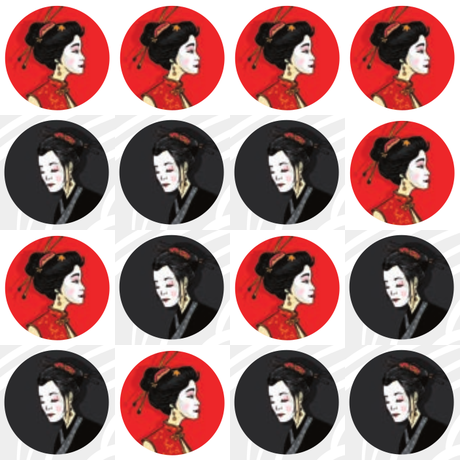

In [13]:
i = 100 # get a 100-th combination, for example
i_bin = bin_interpretation(win_combinations[i], lead_zero_count=16)
tiles = np.array([int(j) for j in i_bin]).reshape([4,4])+16 # 16 is player image bias
draw_tiles(tiles, draw_numbers = False, hi_res = False)
display_image("images/tiles.png")

In [14]:
len(bin_interpretation(2145))

12

In [15]:
(32-12)/4

5.0

In [16]:
bin_interpretation(2145)

'100001100001'

In [17]:
a = bin_interpretation(2145&65535)
int(a,2), a, bin_interpretation(2145>>4)

(2145, '100001100001', '10000110')

In [18]:
bin_interpretation(15), bin_interpretation(2145>>4&15)

('1111', '110')

In [19]:
b = int(''.join(['1' for i in range(16)]),2)
b, bin_interpretation(b)

(65535, '1111111111111111')

In [20]:
b&int(a,2)

2145

In [21]:
int(''.join(['1' for i in range(12)]),2)

4095

In [22]:
2145&4095

2145

In [23]:
256*256

65536

In [24]:
List = [1,2,3,4]
window_size = 2
sum(List[:window_size])

3

In [25]:
len(bin_interpretation(2145))

12

In [35]:
''.join(['1' for i in range(16)])

'1111111111111111'

In [33]:
bin_interpretation(2145)

'100001100001'

In [32]:
int(''.join(['1' for i in range(len(bin_interpretation(len(win_combinations))))]),2)

4095